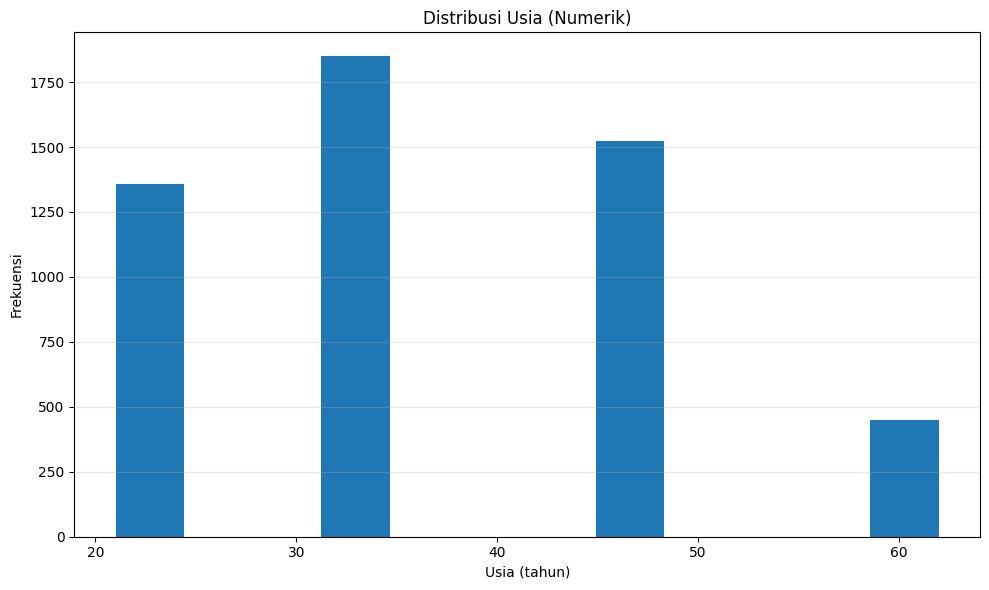

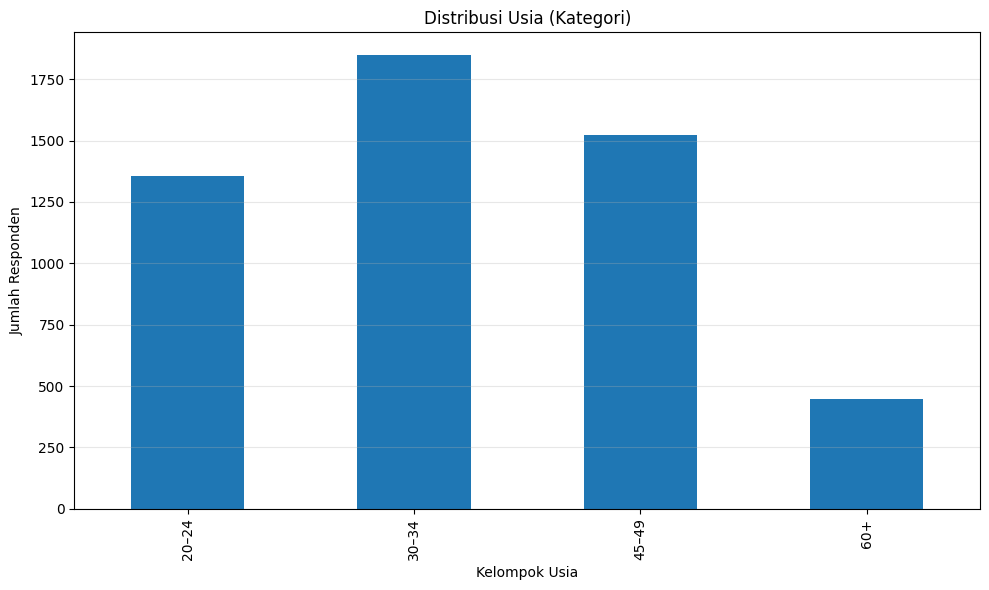

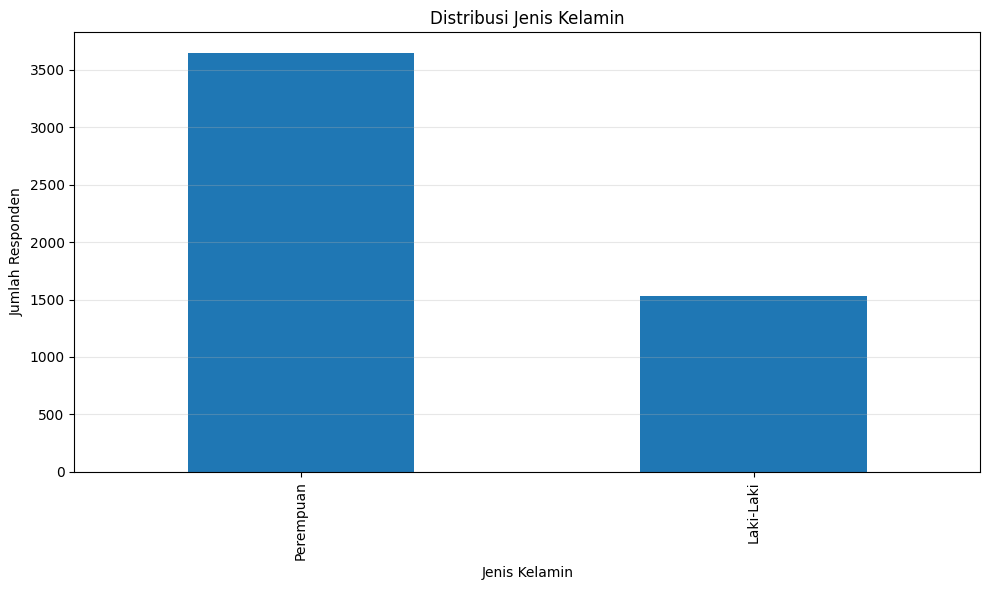

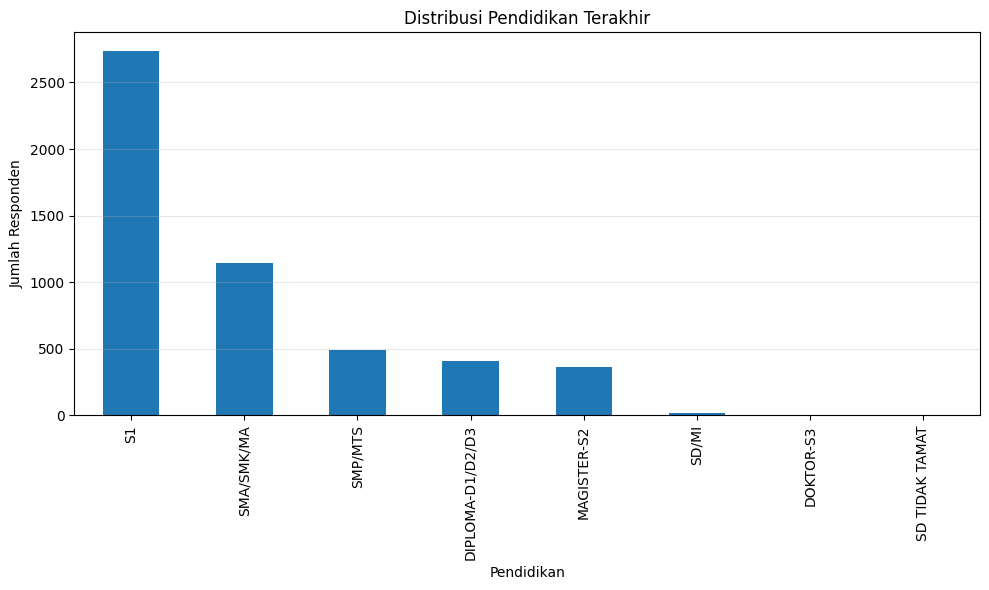

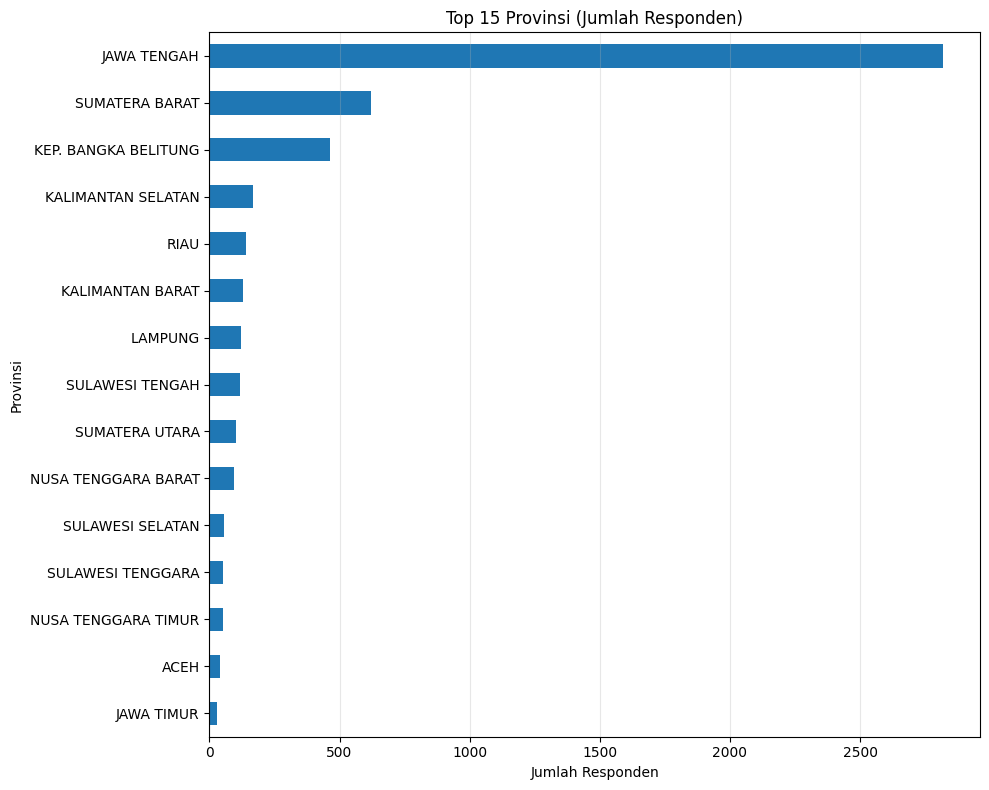

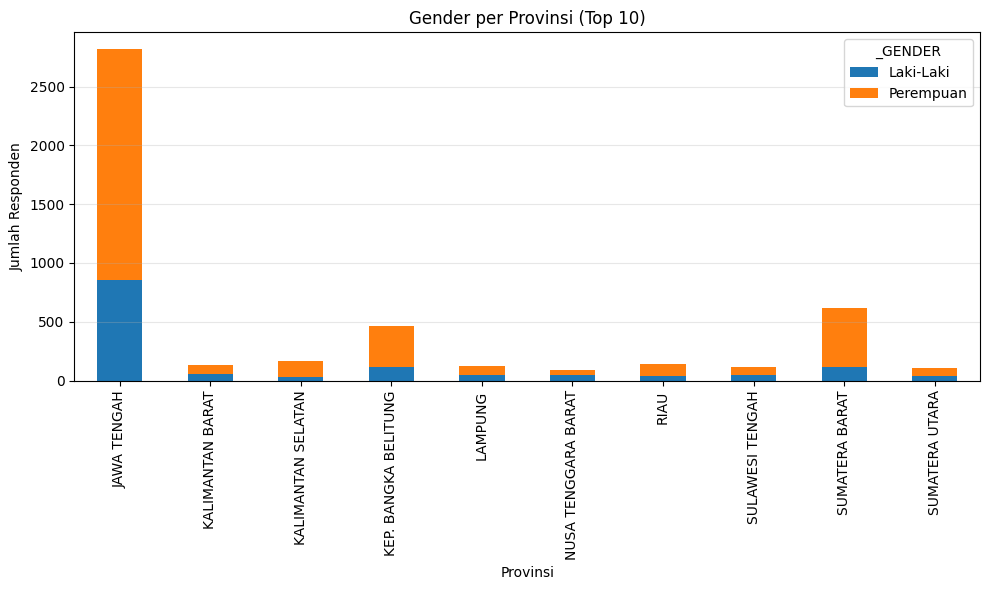

[OK] EDA demografi tersimpan ke: /content/EDA_Demografi.xlsx


In [7]:
# -*- coding: utf-8 -*-
"""
Exploratory Data Analysis (EDA) untuk Data Demografi (kolom A*)
===============================================================
Asumsi struktur kolom:
- A1. Usia
- A2. Jenis Kelamin
- A3. Pendidikan Terakhir
- A4. Pekerjaan
- A5. Provinsi Asal
+ kolom A* lain jika ada

Catatan:
- Script ini fokus EDA demografi: ringkasan, missing values, distribusi,
  tabulasi silang (cross-tab), dan beberapa uji asosiasi dasar.
- Semua grafik menggunakan matplotlib (tanpa seaborn).
- Hasil ringkasan disimpan ke Excel (opsional).
"""

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path

# ================== CONFIG ==================
INPUT_PATH  = Path("TKM_edit.xlsx")   # ganti ke file Anda
SHEET_NAME  = 0
EXPORT_XLSX = True
OUTPUT_XLSX = Path("EDA_Demografi.xlsx")
# ============================================

# ---------- Load & Normalisasi ----------
df = pd.read_excel(INPUT_PATH, sheet_name=SHEET_NAME)
# rapikan nama kolom
df.columns = [re.sub(r"^\s+|\s+$", "", str(c)) for c in df.columns]

# pilih kolom demografi = prefix 'A'
A_cols = [c for c in df.columns if re.match(r"^A", c)]
if not A_cols:
    raise ValueError("Tidak ditemukan kolom berawalan 'A'. Periksa header file Anda.")

A_df = df[A_cols].copy()

# deteksi kolom spesifik (longgar → aman untuk variasi teks)
col_usia      = next((c for c in A_cols if re.search(r'\busia\b|umur', c, flags=re.I)), None)
col_gender    = next((c for c in A_cols if re.search(r'jenis\s*kelamin|gender', c, flags=re.I)), None)
col_pendidikan= next((c for c in A_cols if re.search(r'pendidikan', c, flags=re.I)), None)
col_job       = next((c for c in A_cols if re.search(r'pekerjaan|profesi|jabatan', c, flags=re.I)), None)
col_provinsi  = next((c for c in A_cols if re.search(r'provinsi|propinsi', c, flags=re.I)), None)

# ---------- Helper ----------
def clean_str(s):
    if pd.isna(s): return np.nan
    return str(s).strip()

def parse_age_to_num(x):
    """
    Mendukung bentuk: angka murni ('34'), rentang ('25 - 39 Tahun'),
    label ('40 - 54 Tahun'), atau teks lain → diambil nilai tengah rentang.
    """
    if pd.isna(x): return np.nan
    s = str(x)
    # cari 2 angka (rentang)
    m = re.findall(r'(\d+)', s)
    if not m:
        return np.nan
    nums = list(map(int, m))
    if len(nums) == 1:
        return float(nums[0])
    # jika lebih dari 1 angka → ambil rata2 dua angka pertama
    return float(np.mean(nums[:2]))

def categorize_age(age):
    """
    Kategori usia standar (ubah sesuai kebutuhan):
    <20, 20–24, 25–29, 30–34, 35–39, 40–44, 45–49, 50–54, 55–59, 60+.
    """
    if pd.isna(age): return "Unknown"
    a = float(age)
    bins = [-np.inf, 19, 24, 29, 34, 39, 44, 49, 54, 59, np.inf]
    labels = ["<20","20–24","25–29","30–34","35–39","40–44","45–49","50–54","55–59","60+"]
    return pd.cut([a], bins=bins, labels=labels)[0]

# ---------- Pembersihan kolom utama ----------
if col_usia is not None:
    A_df["_AGE_NUM"] = A_df[col_usia].apply(parse_age_to_num)
    A_df["_AGE_CAT"] = A_df["_AGE_NUM"].apply(categorize_age)

if col_gender is not None:
    A_df["_GENDER"] = A_df[col_gender].map(clean_str).str.title()

if col_pendidikan is not None:
    A_df["_EDU"] = A_df[col_pendidikan].map(clean_str).str.upper()
    # normalisasi label umum (opsional)
    edu_map = {
        "SMP": "SMP", "SMA": "SMA/SMK", "SMK": "SMA/SMK",
        "D3": "D3", "D4/S1": "S1", "SARJANA-D4/S1": "S1",
        "S2": "S2", "S3": "S3"
    }
    A_df["_EDU"] = A_df["_EDU"].replace(edu_map, regex=False)

if col_job is not None:
    A_df["_JOB"] = A_df[col_job].map(clean_str).str.title()

if col_provinsi is not None:
    # seragamkan penulisan
    A_df["_PROV"] = (
        A_df[col_provinsi]
        .astype(str)
        .str.strip()
        .str.upper()
        .str.replace(r"^PROVINSI\s+", "", regex=True)
    )

# ---------- Ringkasan Umum ----------
summary = A_df.describe(include="all").T

missing = A_df.isna().mean().rename("missing_rate").to_frame()
missing["missing_%"] = (missing["missing_rate"] * 100).round(2)

# ---------- Distribusi Dasar ----------
summary_tables = {}

if col_usia is not None:
    age_desc = A_df["_AGE_NUM"].describe().to_frame(name="AGE_NUM")
    age_cat_counts = A_df["_AGE_CAT"].value_counts(dropna=False).sort_index().to_frame(name="count")
    age_cat_counts["%"] = (100 * age_cat_counts["count"] / len(A_df)).round(2)
    summary_tables["AGE_NUM_DESC"] = age_desc
    summary_tables["AGE_CAT_COUNTS"] = age_cat_counts

if col_gender is not None:
    g_counts = A_df["_GENDER"].value_counts(dropna=False).to_frame(name="count")
    g_counts["%"] = (100 * g_counts["count"] / len(A_df)).round(2)
    summary_tables["GENDER_COUNTS"] = g_counts

if col_pendidikan is not None:
    e_counts = A_df["_EDU"].value_counts(dropna=False).to_frame(name="count")
    e_counts["%"] = (100 * e_counts["count"] / len(A_df)).round(2)
    summary_tables["EDU_COUNTS"] = e_counts

if col_job is not None:
    j_counts = A_df["_JOB"].value_counts(dropna=False).head(20).to_frame(name="top20_count")
    summary_tables["JOB_TOP20"] = j_counts

if col_provinsi is not None:
    p_counts = A_df["_PROV"].value_counts(dropna=False).to_frame(name="count")
    p_counts["%"] = (100 * p_counts["count"] / len(A_df)).round(2)
    summary_tables["PROVINCE_COUNTS"] = p_counts

# ---------- Cross-Tab (contoh) ----------
crosstabs = {}

if col_gender is not None and col_provinsi is not None:
    ct_gender_prov = pd.crosstab(A_df["_PROV"], A_df["_GENDER"], margins=True)
    crosstabs["PROVxGENDER"] = ct_gender_prov

if col_pendidikan is not None and col_provinsi is not None:
    ct_edu_prov = pd.crosstab(A_df["_PROV"], A_df["_EDU"], margins=True)
    crosstabs["PROVxEDU"] = ct_edu_prov

if col_usia is not None and col_provinsi is not None:
    ct_agecat_prov = pd.crosstab(A_df["_PROV"], A_df["_AGE_CAT"], margins=True)
    crosstabs["PROVxAGECAT"] = ct_agecat_prov

# ---------- Grafik ----------
plt.rcParams["figure.figsize"] = (10, 6)

# 1) Histogram usia (numerik)
if col_usia is not None:
    plt.figure()
    A_df["_AGE_NUM"].dropna().plot(kind="hist", bins=12)
    plt.title("Distribusi Usia (Numerik)")
    plt.xlabel("Usia (tahun)")
    plt.ylabel("Frekuensi")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()

# 2) Bar chart kategori usia
if col_usia is not None:
    plt.figure()
    age_cat_counts["count"].plot(kind="bar")
    plt.title("Distribusi Usia (Kategori)")
    plt.xlabel("Kelompok Usia")
    plt.ylabel("Jumlah Responden")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()

# 3) Bar chart gender
if col_gender is not None:
    plt.figure()
    g_counts["count"].plot(kind="bar")
    plt.title("Distribusi Jenis Kelamin")
    plt.xlabel("Jenis Kelamin")
    plt.ylabel("Jumlah Responden")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()

# 4) Bar chart pendidikan
if col_pendidikan is not None:
    plt.figure()
    e_counts["count"].plot(kind="bar")
    plt.title("Distribusi Pendidikan Terakhir")
    plt.xlabel("Pendidikan")
    plt.ylabel("Jumlah Responden")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()

# 5) Top 15 provinsi
if col_provinsi is not None:
    plt.figure(figsize=(10, 8))
    p_counts.head(15).iloc[::-1]["count"].plot(kind="barh")
    plt.title("Top 15 Provinsi (Jumlah Responden)")
    plt.xlabel("Jumlah Responden")
    plt.ylabel("Provinsi")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()

# 6) Stacked bar: Gender per Provinsi (Top 10)
if col_gender is not None and col_provinsi is not None:
    top_prov = A_df["_PROV"].value_counts().head(10).index
    tmp = pd.crosstab(A_df.loc[A_df["_PROV"].isin(top_prov), "_PROV"],
                      A_df.loc[A_df["_PROV"].isin(top_prov), "_GENDER"])
    tmp.plot(kind="bar", stacked=True, figsize=(10, 6))
    plt.title("Gender per Provinsi (Top 10)")
    plt.xlabel("Provinsi")
    plt.ylabel("Jumlah Responden")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()

plt.show()

# ---------- Simpan ringkasan ke Excel ----------
if EXPORT_XLSX:
    with pd.ExcelWriter(OUTPUT_XLSX, engine="xlsxwriter") as writer:
        A_df.to_excel(writer, sheet_name="A_raw_clean", index=False)
        summary.to_excel(writer, sheet_name="summary_all_fields")
        missing.to_excel(writer, sheet_name="missing_rates")
        for name, tab in summary_tables.items():
            tab.to_excel(writer, sheet_name=name)
        for name, tab in crosstabs.items():
            tab.to_excel(writer, sheet_name=name)

    print(f"[OK] EDA demografi tersimpan ke: {OUTPUT_XLSX.resolve()}")
else:
    print("[OK] EDA demografi selesai (tanpa ekspor Excel).")


In [3]:
# -*- coding: utf-8 -*-
%pip install xlsxwriter
"""
Hitung indeks komposit TKM per responden & rekap per provinsi
=============================================================
Asumsi struktur kolom:
- A* = Demografi (termasuk A5. Provinsi Asal)
- B* = Pra Membaca     (bobot 15%)
- C* = Saat Membaca    (bobot 50%)
- D* = Pasca Membaca   (bobot 35%)
- E* = Faktor Y        (disimpan, tidak memengaruhi indeks)
Skala Likert dipetakan otomatis ke 1..5 (beberapa kamus umum).
"""

import pandas as pd
import numpy as np
import re
from pathlib import Path

# ======================== CONFIG ========================
INPUT_PATH  = Path("TKM_edit.xlsx")    # ganti sesuai lokasi file Anda
SHEET_NAME  = 0                        # index atau nama sheet
OUTPUT_PATH = Path("TKM_index_by_province.xlsx")

# Bobot komposit
W_B = 0.15  # Pra Membaca
W_C = 0.50  # Saat Membaca
W_D = 0.35  # Pasca Membaca
# ========================================================


# ---------- Utilitas ----------
LIKERT_MAPPINGS = [
    # Setujuan
    {
        "Sangat Tidak Setuju": 1, "Tidak Setuju": 2, "Netral": 3, "Setuju": 4, "Sangat Setuju": 5,
        "STS": 1, "TS": 2, "N": 3, "S": 4, "SS": 5
    },
    # Frekuensi
    {
        "Tidak Pernah": 1, "Jarang": 2, "Kadang-kadang": 3, "Sering": 4, "Selalu": 5,
        "TP": 1, "J": 2, "KK": 3, "Sr": 4, "Sl": 5
    },
    # Kualitas umum
    {
        "Sangat Buruk": 1, "Buruk": 2, "Cukup": 3, "Baik": 4, "Sangat Baik": 5
    }
]

def to_float_or_nan(x):
    """Coba ubah string ke float (dukung koma sebagai desimal)."""
    try:
        if pd.isna(x):
            return np.nan
        xs = str(x).strip().replace(",", ".")
        return float(xs)
    except Exception:
        return np.nan

def map_likert_series(s: pd.Series) -> pd.Series:
    """
    Konversi jawaban ke 1..5:
    - Jika sudah numerik → float
    - Jika teks → coba mapping likert (>=60% coverage)
    - Jika gagal → coba ekstrak angka float dari string
    - Jika tetap gagal → NaN
    """
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(float)

    s_str = s.astype(str).str.strip()

    # Coba kamus likert
    for mapping in LIKERT_MAPPINGS:
        mapped = s_str.map(mapping).astype(float)
        if mapped.notna().mean() >= 0.60:
            return mapped

    # Coba angka langsung
    numeric_guess = s_str.apply(to_float_or_nan)
    if numeric_guess.notna().mean() >= 0.50:
        return numeric_guess

    # Gagal → NaN
    return pd.Series([np.nan] * len(s), index=s.index)

def safe_row_mean(df: pd.DataFrame, cols) -> pd.Series:
    """Rata-rata baris dengan skipna (jika cols kosong → NaN)."""
    if not cols:
        return pd.Series(np.nan, index=df.index)
    return df[cols].mean(axis=1, skipna=True)

def to_0_100(x, low=1.0, high=5.0):
    """Ubah skala 1..5 menjadi 0..100."""
    return ((x - low) / (high - low)) * 100.0


# ---------- Load & Normalisasi ----------
df = pd.read_excel(INPUT_PATH, sheet_name=SHEET_NAME)
df.columns = [str(c).strip() for c in df.columns]     # trim spasi
# (opsional) hilangkan newline awal seperti "\nB1..." → "B1..."
df.columns = [re.sub(r"^\s+", "", c) for c in df.columns]

# Deteksi kolom provinsi (regex fleksibel)
province_col = None
for col in df.columns:
    if re.search(r'\bprovinsi|\bpropinsi', col, flags=re.IGNORECASE):
        province_col = col
        break
if province_col is None:
    # fallback: buat kolom provinsi dummy agar kode tetap jalan
    province_col = "Provinsi"
    if province_col not in df.columns:
        df[province_col] = "UNKNOWN"

# Kelompokkan kolom berdasarkan prefix A/B/C/D/E
A_cols = [c for c in df.columns if re.match(r'^A', c)]
B_cols = [c for c in df.columns if re.match(r'^B', c)]
C_cols = [c for c in df.columns if re.match(r'^C', c)]
D_cols = [c for c in df.columns if re.match(r'^D', c)]
E_cols = [c for c in df.columns if re.match(r'^E', c)]

# ---------- Konversi jawaban B/C/D ke numerik ----------
df_num = df.copy()
for col in (B_cols + C_cols + D_cols):
    df_num[col] = map_likert_series(df[col])

# ---------- Skor rata-rata per blok ----------
df_num["Pra_B_mean"]    = safe_row_mean(df_num, B_cols)  # Pra Membaca
df_num["Saat_C_mean"]   = safe_row_mean(df_num, C_cols)  # Saat Membaca
df_num["Pasca_D_mean"]  = safe_row_mean(df_num, D_cols)  # Pasca Membaca

# ---------- Indeks komposit ----------
df_num["Composite_1_to_5"] = (
    W_B * df_num["Pra_B_mean"] +
    W_C * df_num["Saat_C_mean"] +
    W_D * df_num["Pasca_D_mean"]
)
df_num["Composite_0_to_100"] = to_0_100(df_num["Composite_1_to_5"])

# ---------- Rekap per provinsi ----------
province_summary = (
    df_num
    .groupby(province_col, dropna=False)
    .agg(
        n_responden            = (province_col, "size"),
        Pra_B_mean_avg         = ("Pra_B_mean", "mean"),
        Saat_C_mean_avg        = ("Saat_C_mean", "mean"),
        Pasca_D_mean_avg       = ("Pasca_D_mean", "mean"),
        Composite_1_to_5_avg   = ("Composite_1_to_5", "mean"),
        Composite_0_to_100_avg = ("Composite_0_to_100", "mean"),
    )
    .reset_index()
    .sort_values("Composite_0_to_100_avg", ascending=False)
)

# ---------- Simpan ke Excel ----------
with pd.ExcelWriter(OUTPUT_PATH, engine="xlsxwriter") as writer:
    # Sheet 1: skor per responden (ikutkan A/B/C/D/E + skor)
    keep_cols = (
        [province_col] + A_cols + B_cols + C_cols + D_cols + E_cols +
        ["Pra_B_mean", "Saat_C_mean", "Pasca_D_mean",
         "Composite_1_to_5", "Composite_0_to_100"]
    )
    # dedup dan pastikan kolom ada
    seen, keep_cols_unique = set(), []
    for c in keep_cols:
        if c in df_num.columns and c not in seen:
            keep_cols_unique.append(c)
        seen.add(c)

    df_num[keep_cols_unique].to_excel(writer, sheet_name="individual_scores", index=False)
    province_summary.to_excel(writer, sheet_name="province_summary", index=False)

print(f"Done. File tersimpan: {OUTPUT_PATH.resolve()}")


Done. File tersimpan: /content/TKM_index_by_province.xlsx


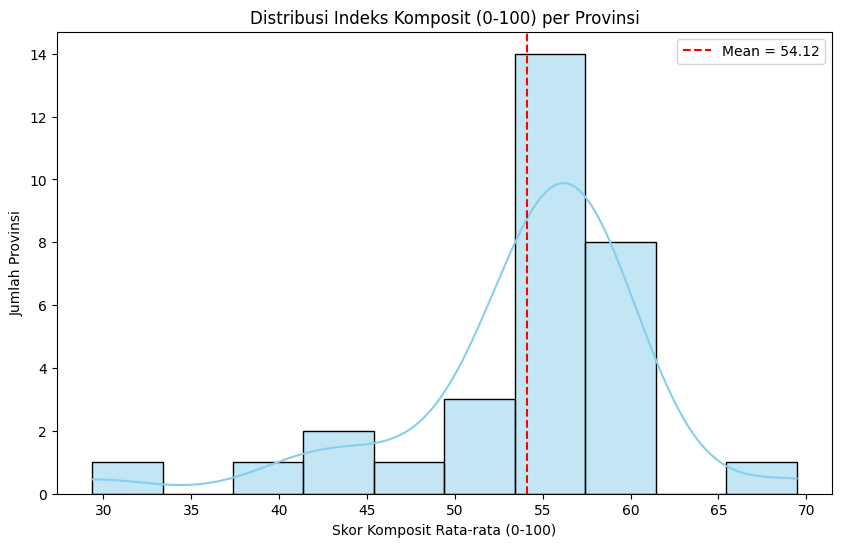

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil data composite per provinsi (0-100)
scores = province_summary["Composite_0_to_100_avg"].dropna()

plt.figure(figsize=(10,6))
sns.histplot(scores, kde=True, bins=10, color="skyblue", edgecolor="black")

plt.title("Distribusi Indeks Komposit (0-100) per Provinsi")
plt.xlabel("Skor Komposit Rata-rata (0-100)")
plt.ylabel("Jumlah Provinsi")

# Tambahkan garis mean
mean_score = scores.mean()
plt.axvline(mean_score, color="red", linestyle="--", label=f"Mean = {mean_score:.2f}")
plt.legend()

plt.show()


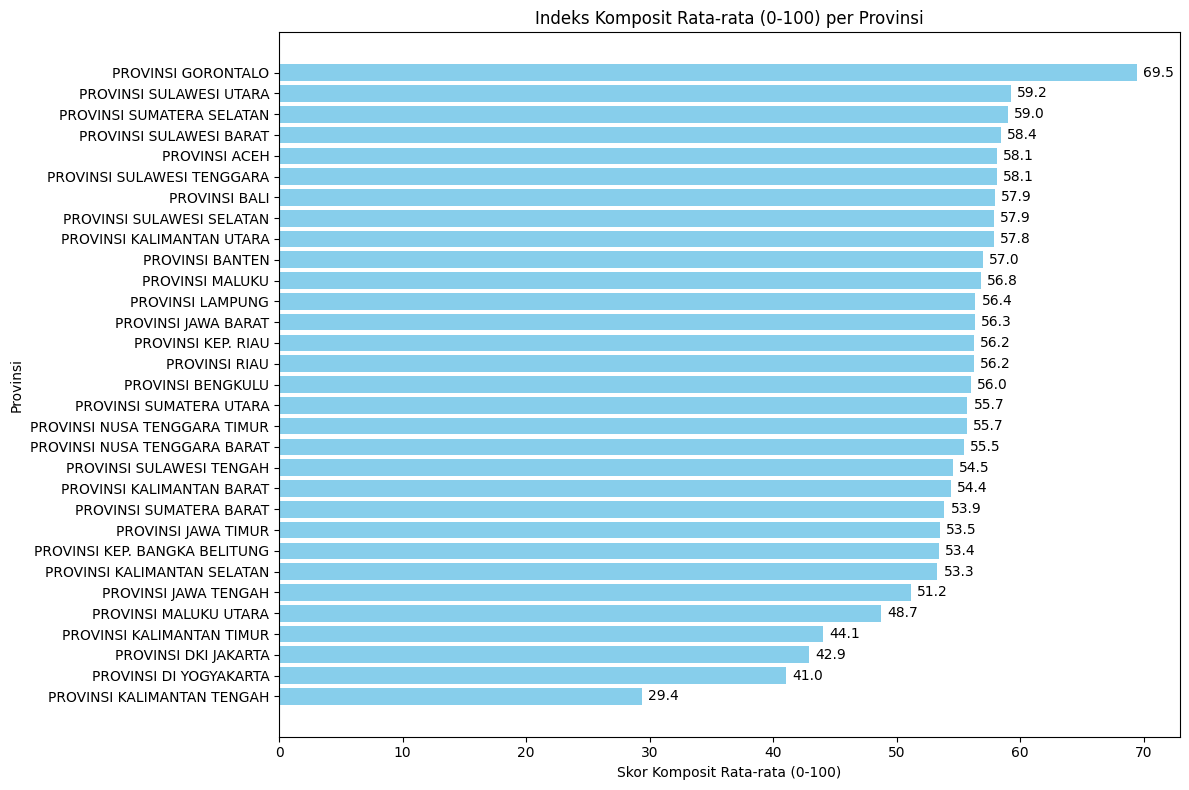

In [5]:
import matplotlib.pyplot as plt

# Urutkan provinsi berdasarkan nilai komposit
sorted_data = province_summary.sort_values("Composite_0_to_100_avg", ascending=True)

plt.figure(figsize=(12,8))
bars = plt.barh(sorted_data[province_col], sorted_data["Composite_0_to_100_avg"], color="skyblue")

# Tambahkan nilai di ujung bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}", va='center')

plt.title("Indeks Komposit Rata-rata (0-100) per Provinsi")
plt.xlabel("Skor Komposit Rata-rata (0-100)")
plt.ylabel("Provinsi")
plt.tight_layout()
plt.show()


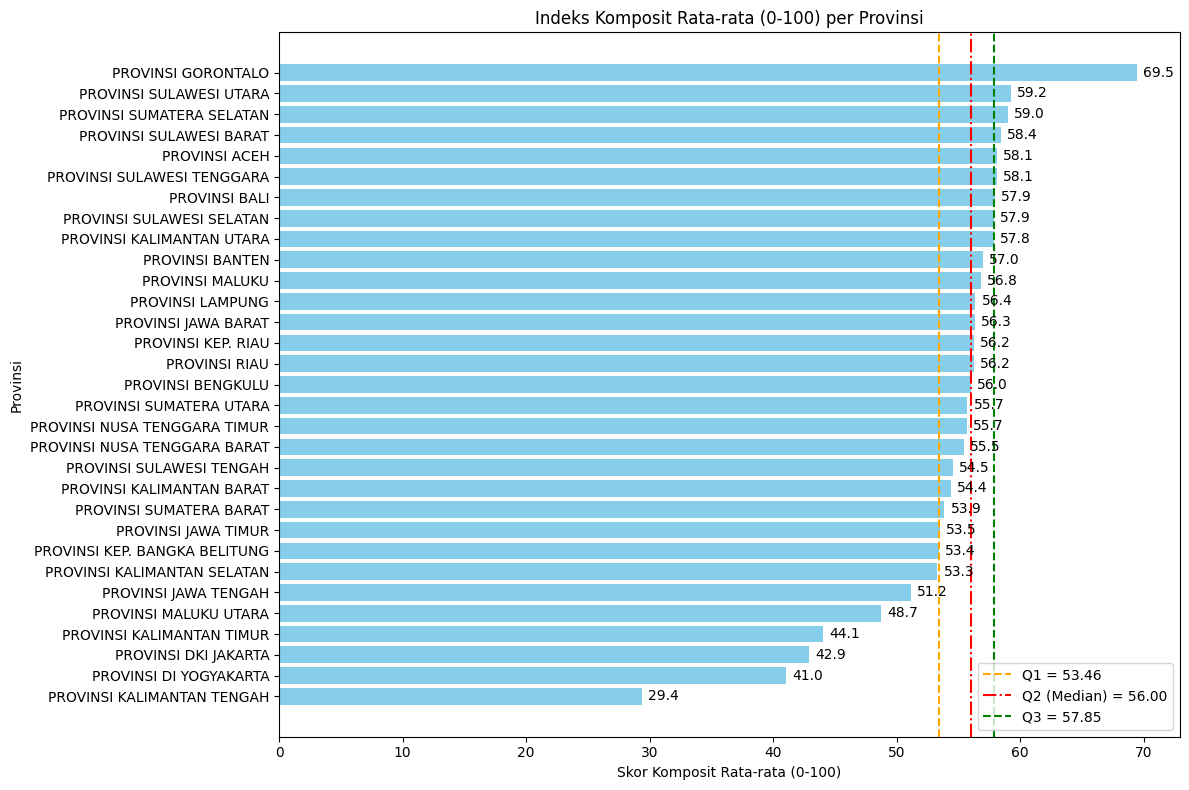

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Urutkan provinsi berdasarkan nilai komposit
sorted_data = province_summary.sort_values("Composite_0_to_100_avg", ascending=True)

# Hitung kuartil
q1 = np.percentile(sorted_data["Composite_0_to_100_avg"], 25)
q2 = np.percentile(sorted_data["Composite_0_to_100_avg"], 50)  # median
q3 = np.percentile(sorted_data["Composite_0_to_100_avg"], 75)

plt.figure(figsize=(12,8))
bars = plt.barh(sorted_data[province_col],
                sorted_data["Composite_0_to_100_avg"],
                color="skyblue")

# Tambahkan nilai di ujung bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}", va='center')

# Tambahkan garis vertikal untuk Q1, Q2, Q3
plt.axvline(q1, color="orange", linestyle="--", label=f"Q1 = {q1:.2f}")
plt.axvline(q2, color="red", linestyle="-.", label=f"Q2 (Median) = {q2:.2f}")
plt.axvline(q3, color="green", linestyle="--", label=f"Q3 = {q3:.2f}")

plt.title("Indeks Komposit Rata-rata (0-100) per Provinsi")
plt.xlabel("Skor Komposit Rata-rata (0-100)")
plt.ylabel("Provinsi")
plt.legend()
plt.tight_layout()
plt.show()
